# Learning PYCBC
Going to have a look at simulating a signal close to first detection, then applying it to detectors and using the comparison tools

In [13]:
import matplotlib.pyplot as plt
import warnings
from pycbc.detector import Detector
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.catalog import Merger
from pycbc.filter import highpass_fir, lowpass_fir, matched_filter
from pycbc.psd import welch, interpolate
import numpy as np
import pandas as pd


warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [3]:
#going to make a signal processing function, just looking at h1 for now

def signal_process(event):
    h1 = event.strain("H1")
    h1 = highpass_fir(h1, 15, 8)

    # Calculate the noise spectrum
    psd = interpolate(welch(h1), 1.0 / h1.duration)

    # whiten
    white_strain = (h1.to_frequencyseries() / psd ** 0.5).to_timeseries()

    # remove some of the high and low
    smooth = highpass_fir(white_strain, 35, 8)
    smooth = lowpass_fir(smooth, 300, 8)

    return smooth

In [18]:
#nabbed from chatgpt just because it makes them match lengths first

def td_match(h1, h2):
    """Compute a simple normalized time-domain correlation between two signals."""
    # Convert to numpy arrays if needed
    if hasattr(h1, 'numpy'):
        h1 = h1.numpy()
    if hasattr(h2, 'numpy'):
        h2 = h2.numpy()

    # Ensure same length
    n = min(len(h1), len(h2))
    h1 = h1[:n]
    h2 = h2[:n]

    # Zero-mean
    h1 = h1 - np.mean(h1)
    h2 = h2 - np.mean(h2)

    # Normalize and correlate
    norm1 = np.sqrt(np.sum(h1**2))
    norm2 = np.sqrt(np.sum(h2**2))
    corr = np.correlate(h1, h2, mode='valid')[0] / (norm1 * norm2)

    return corr

In [ ]:
#simulating simliar conditions

first_ob = Merger("GW150914")
data = signal_process(first_ob)

# These params work p good
# ra = 1.375
# dec = -1.2108
# psi = 0
# time = 1126259462.4
psi = 0
sf = 9.997489117579705e+22

ras = np.linspace(1.32,1.4,50)
decs = np.linspace(-1.15,-1.23,50)
times = np.linspace(1126259462.35, 1126259462.45, 60)

model = "IMRPhenomXP"
det_h1 = Detector("H1")

#lazy approach but so am i
results = []

for ra in ras:
    for dec in decs:
        for time in times:
            hp, hc = get_td_waveform(approximant=model,
                                            mass1=36,
                                            mass2=29,
                                            delta_t=1/4096,
                                            f_lower=20,
                                            distance=410)

            hp.start_time += time
            hc.start_time += time

            test_data = data.time_slice(hp.end_time-0.5,hp.end_time)

            signal_h1 = det_h1.project_wave(hp, hc, ra, dec, psi)

            m = td_match(test_data, signal_h1.time_slice(hp.end_time-0.5,hp.end_time))
            results.append([ra,dec,time,m])

df = pd.DataFrame(results, columns=["ra", "dec", "time", "match"])
print(df.sort_values("match", ascending=False).head())


#last best was 0.24

            ra       dec          time     match
43    1.335000 -1.165000  1.126259e+09  0.245263
2043  1.336667 -1.165000  1.126259e+09  0.245182
93    1.335000 -1.166667  1.126259e+09  0.245105
4043  1.338333 -1.165000  1.126259e+09  0.245100
2093  1.336667 -1.166667  1.126259e+09  0.245021


1126259460.804969788 1126259462.517616272
1.030977137867099e+23


(-150.0, 150.0)

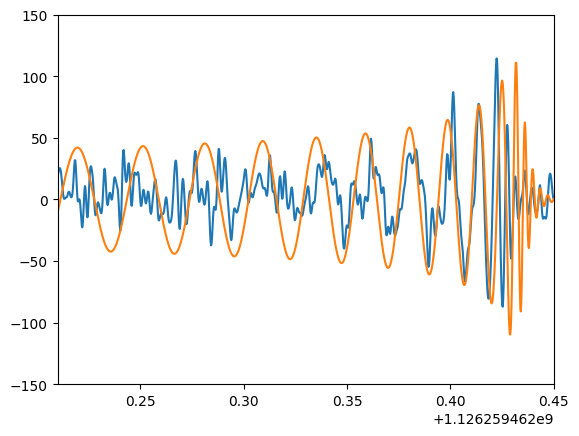

In [78]:
best_row = df.loc[df['match'].idxmax()]
params = best_row.drop('match').to_dict()

hp, hc = get_td_waveform(approximant=model,
                                mass1=36,
                                mass2=29,
                                delta_t=1/4096,
                                f_lower=20,
                                distance=410)



hp.start_time += params["time"]
hc.start_time += params["time"]

signal_h1 = det_h1.project_wave(hp, hc, params["ra"], params["dec"], psi).time_slice(1126259462.2,1126259462.5)
data = data.time_slice(1126259462.2,1126259462.5)

print(hp.start_time, hp.end_time)
print(max(data)/max(signal_h1))

plt.plot(data.sample_times, data)
plt.plot(signal_h1.sample_times, signal_h1*sf)
plt.xlim(1126259462.21, 1126259462.45)
plt.ylim(-150, 150)